In [1]:
import os, re, json, time
import PIL.Image, PIL.ImageFont, PIL.ImageDraw

import tensorflow as tf
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt

## Utility Functions

In [2]:
#@title Visualization Utilities[RUN ME]
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")
# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

## Define Parameters

In [3]:
BATCH_SIZE = 32 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Load and Preprocess Datasets

In [4]:
(training_images, training_labels), (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


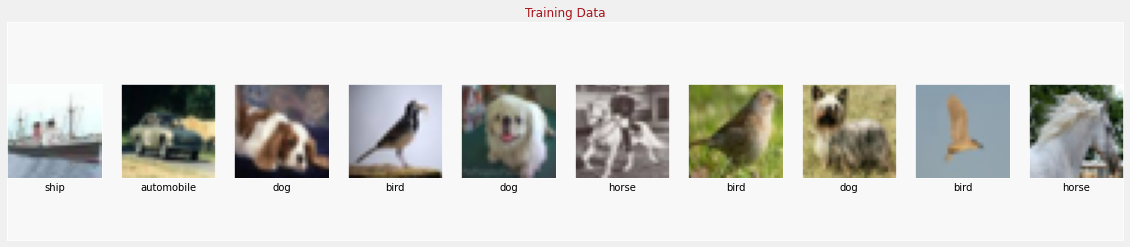

In [5]:
display_images(training_images, training_labels, training_labels, "Training Data" )


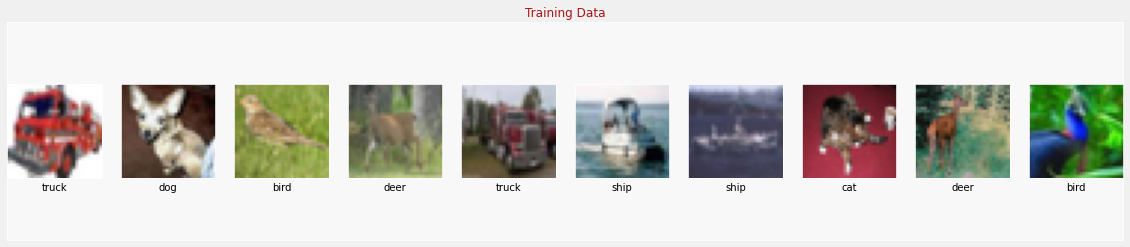

In [6]:
display_images(validation_images, validation_labels, validation_labels, "Training Data" )


In [7]:
def preprocess_image_input(input_images):
    input_images = tf.cast(input_images, tf.float32)
    output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
    return output_ims

In [8]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

## Define the Network

In [9]:
def feature_extractor(inputs):
    '''
    Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
    Input size is 224 x 224.
    '''
    feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                                              include_top=False,
                                                              weights='imagenet')(inputs)
    return feature_extractor                                                              

def classifier(inputs):
    '''
    Defines final dense layers and subsequent softmax layer for classification.
    '''
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(10, activation='softmax', name='classification')(x)
    return x

def final_model(inputs):
    '''
    Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
    Connect the feature extraction and "classifier" layers to build the model.
    '''
    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)
    return classification_output

def define_compile_model():
    '''
    Define the model and compile it. 
    Use Stochastic Gradient Descent as the optimizer.
    Use Sparse Categorical CrossEntropy as the loss function.
    '''
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)

    model.compile(optimizer='SGD',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = define_compile_model()
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
______________________________________________________________

## Train the Model

In [10]:
EPOCHS = 4
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data=(valid_X, validation_labels), batch_size=64)

Epoch 1/4
782/782 [==============================] - 548s 652ms/step - loss: 0.4031 - accuracy: 0.8674 - val_loss: 0.2187 - val_accuracy: 0.9239
Epoch 2/4
782/782 [==============================] - 508s 649ms/step - loss: 0.1034 - accuracy: 0.9656 - val_loss: 0.2272 - val_accuracy: 0.9259
Epoch 3/4
782/782 [==============================] - 508s 650ms/step - loss: 0.0353 - accuracy: 0.9901 - val_loss: 0.1739 - val_accuracy: 0.9473
Epoch 4/4
782/782 [==============================] - 508s 650ms/step - loss: 0.0150 - accuracy: 0.9963 - val_loss: 0.1620 - val_accuracy: 0.9538


## Evaluate the Model


In [11]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 31s 197ms/step - loss: 0.1620 - accuracy: 0.9538


## Plot loss and accuracy curves

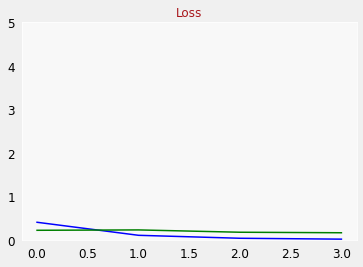

In [12]:
plot_metrics("loss", "Loss")

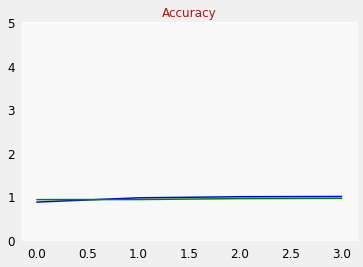

In [13]:
plot_metrics("accuracy", "Accuracy")

## Visualize Predictions

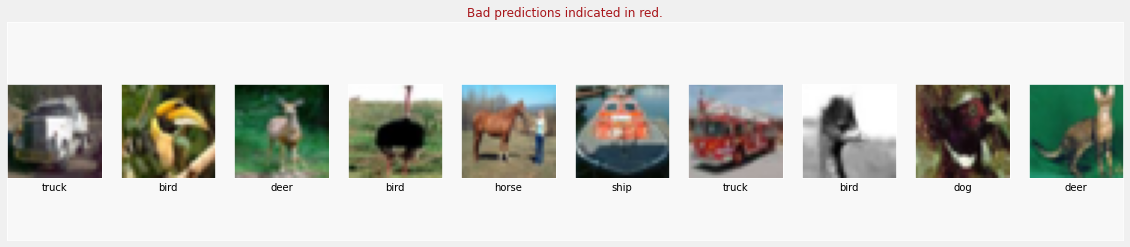

In [14]:
probabilities = model.predict(valid_X, batch_size=64)
probabilities = np.argmax(probabilities, axis = 1)

display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")